### Ablation Study: Loss $\mathcal L_\mathrm{geo,unc}$, dataset $\mathcal S$

In [1]:
import multiprocessing as mp
import numpy as np

In [2]:
def objective_process(result_queue):
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import numpy as np
    
    import DissimilarityMetrics
    import ChannelChartingCore
    import Evaluation

    import dichasus_cf0x

    print("Loading Dataset...")
    groundtruth_positions = []
    csi_time_domain = []
    timestamps = []
    
    for csi, pos, time in dichasus_cf0x.trainingset.batch(1000):
        csi_time_domain.append(csi.numpy())
        groundtruth_positions.append(pos.numpy())
        timestamps.append(time.numpy())
    
    csi_time_domain = np.concatenate(csi_time_domain)
    groundtruth_positions = np.concatenate(groundtruth_positions)
    timestamps = np.concatenate(timestamps)
    
    MEASUREMENT_INTERVAL = 0.048
    timestamps = timestamps - timestamps[0]
    timestamps = np.round(timestamps / MEASUREMENT_INTERVAL) * MEASUREMENT_INTERVAL

    Evaluation.plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")

    def mean_variance_from_delta_adp(delta_adp):
        mean = np.where(delta_adp == 0, 0, np.where(delta_adp > 18, np.inf, delta_adp * 0.0028 + 0.0024))
        variance = np.where(delta_adp == 0, 0, np.where(delta_adp > 18, np.inf, 0.015 * mean))
    
        return mean, variance
    
    adp_metric = DissimilarityMetrics.ADPDissimilarityMetric(csi_time_domain, mean_variance_from_delta_adp)    

    velocity_mean = 0.235
    velocity_variance = 0.010
    
    # Make worste-case assumption of perfectly correlated velocities. This maximizes the variance.
    velocity_metric = DissimilarityMetrics.VelocityDissimilarityMetric(velocity_mean, velocity_variance, True, timestamps)

    GDM = ChannelChartingCore.GaussianDissimilarityModel([adp_metric, velocity_metric])
    GDM.generate_short_paths(total_path_count = 40000, realization_count = 8)

    MIN_BATCH_SIZE = 500
    MAX_BATCH_SIZE = 4000
    LEARNING_RATE_INITIAL = 1.5e-2
    LEARNING_RATE_FINAL = 1e-2
    MAX_HOPLENGTH = 20.0
    MIN_HOPLENGTH = 0.1
    TRAINING_BATCHES = 3000
    ACCELERATION_MEAN = 0.0
    ACCELERATION_VARIANCE = 0.5

    # Ablation study: Disable acceleration loss component
    ACCELERATION_WEIGHT = 0#1e-4

    plot_callback = None # Evaluation.PlotChartCallback(groundtruth_positions, csi_time_domain.shape[0], max_hops = MAX_PATHHOPS)
    cc = ChannelChartingCore.ChannelChart(GDM, csi_time_domain, timestamps, min_batch_size = MIN_BATCH_SIZE, max_batch_size = MAX_BATCH_SIZE, learning_rate_initial = LEARNING_RATE_INITIAL, learning_rate_final = LEARNING_RATE_FINAL, max_hoplength = MAX_HOPLENGTH, min_hoplength = MIN_HOPLENGTH, randomize_pathhops = False, training_batches = TRAINING_BATCHES, plot_callback = plot_callback, acceleration_mean = ACCELERATION_MEAN, acceleration_variance = ACCELERATION_VARIANCE, acceleration_weight = ACCELERATION_WEIGHT)

    channel_chart_positions = cc.predict(csi_time_domain)
    ct, tw, ks = Evaluation.ct_tw_ks_on_subset(groundtruth_positions, channel_chart_positions)
    print(f"CT: {ct:.4f}\nTW: {tw:.4f}\nKS: {ks:.4f}")

    channel_chart_positions_transformed, errorvectors, errors, mae, cep = Evaluation.mean_absolute_error_transformed(groundtruth_positions, channel_chart_positions)
    Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "CC After Affine Transform")
    drms = np.sqrt(np.mean(np.square(errors)))
    
    print(f"MAE: {mae:.4f}\nCEP: {cep:.4f}\nDRMS: {drms:.4f}")
    loss = cc.history.history["loss"][-1]
    print(cc.history.history["loss"])
    print(f"Loss: {loss:.4f}")
    
    result_queue.put((mae, cep, drms, loss))

In [3]:
maes = []
ceps = []
drmss = []
losses = []

result_queue = mp.Queue()

In [ ]:
for i in range(30):
    p = mp.Process(target=objective_process, args=(result_queue,))
    p.start()
    p.join()

    mae, cep, drms, loss = result_queue.get()
    maes.append(mae)
    ceps.append(cep)
    drmss.append(drms)
    losses.append(loss)

2024-12-03 22:14:39.408995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 22:14:40.196415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-03 22:14:41.432917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 22:14:41.486891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


In [16]:
maes = np.asarray(maes)
ceps = np.asarray(ceps)
drmss = np.asarray(drmss)
losses = np.asarray(losses)

In [17]:
import matplotlib.pyplot as plt

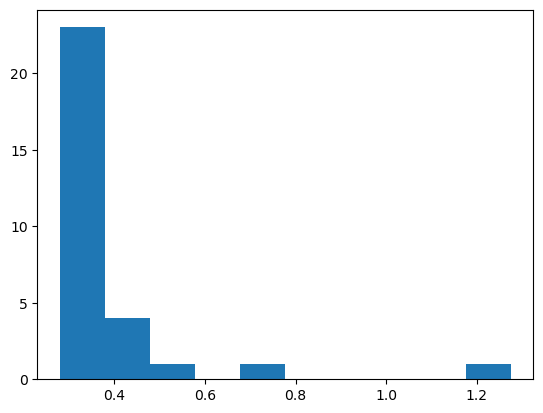

In [18]:
plt.hist(maes)
plt.show()

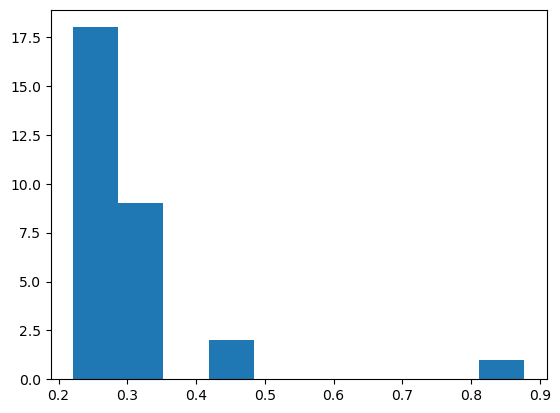

In [19]:
plt.hist(ceps)
plt.show()

In [20]:
print(f"Mean MAE: {np.mean(maes):.3f}")
print(f"Mean CEP: {np.mean(ceps):.3f}")

Mean MAE: 0.393
Mean CEP: 0.308


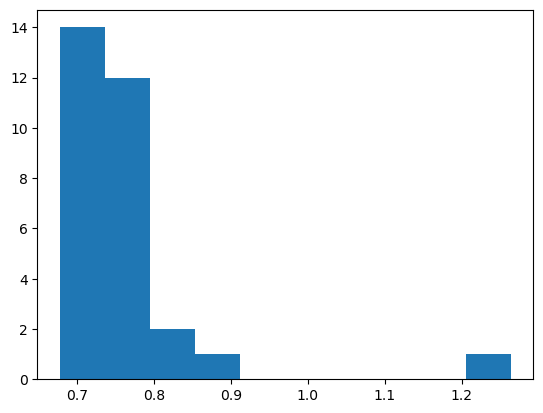

In [21]:
plt.hist(losses)
plt.show()

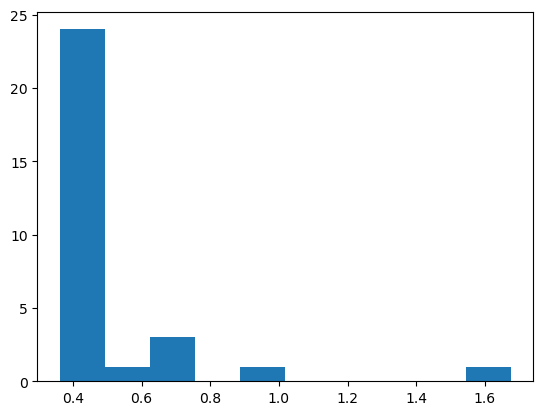

In [22]:
plt.hist(drmss)
plt.show()

In [23]:
print(f"Mean MAE : {np.mean(maes):.3f}")
print(f"Mean CEP : {np.mean(ceps):.3f}")
print(f"Mean DRMS: {np.mean(drmss):.3f}")

Mean MAE : 0.393
Mean CEP : 0.308
Mean DRMS: 0.510


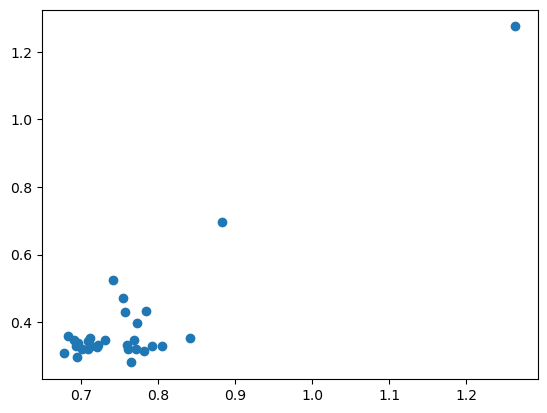

In [24]:
plt.scatter(losses, maes)
plt.show()

In [25]:
loss_sort_order = np.argsort(losses)

In [26]:
# Here, we use the results only for the training passes with the lowest losses, since we can detect if training has not found the global optimum
print("Results for 20 training passes with lowest loss")
print(f"Mean MAE : {np.mean(maes[loss_sort_order][:20]):.3f}")
print(f"Mean CEP : {np.mean(ceps[loss_sort_order][:20]):.3f}")
print(f"Mean DRMS: {np.mean(drmss[loss_sort_order][:20]):.3f}")

Results for 20 training passes with lowest loss
Mean MAE : 0.350
Mean CEP : 0.283
Mean DRMS: 0.452
